**Author**: J W Debelius<br/>
**Date**: 1 July 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

#Table of Contents
* [1. Introduction](#1.-Introduction)
* [2. Case I T test](#2.-Case-I-T-test)
	* [2.1 Effect Size](#2.1-Effect-Size)
	* [2.2 Emperical test](#2.2-Emperical-test)
	* [2.3 Extrapolated Power](#2.3-Extrapolated-Power)
	* [2.4 Simulation Paramters](#2.4-Simulation-Paramters)
* [3. Case II T test](#3.-Case-II-T-test)
	* [3.1 Test Parameters](#3.1-Test-Parameters)
	* [3.2 Effect size](#3.2-Effect-size)
	* [3.3 Simulation Parameters](#3.3-Simulation-Parameters)
* [4. ANOVA](#4.-ANOVA)
	* [4.1 Emperical Test](#4.1-Emperical-Test)
	* [4.2 Effect Size](#4.2-Effect-Size)
	* [4.3 Simple Linear Regression](#4.3-Simple-Linear-Regression)
* [5. Effect Size](#5.-Effect-Size)
	* [5.1 Emperical Test](#5.1-Emperical-Test)
* [6. Simulation Model](#6.-Simulation-Model)
* [7. Pearson's R](#7.-Pearson's-R)
	* [7.1 Effect Size](#7.1-Effect-Size)
	* [7.2 Emperical Test](#7.2-Emperical-Test)
	* [7.3 Simulation](#7.3-Simulation)
* [8. Build simulations](#8.-Build-simulations)


# 1. Introduction

This notebook assumes you already understand the idea of hypothesis testing, statistical power, and the types of error which can occur with hypothesis testing. There are several better, more prolific treatises on the topic, including 

[citations here]

Fundementally, these will tell us that the probability of a false positive, $\beta$ can be expressed as


$\beta(n) =\beta\left(n \right ) = P\left [S'(n,k) \geq S_{1-\alpha/2}(k)  \right ]\tag{1}$
where $S'$ is the test statistic, and $S$ is the distribution, $k$ are the parameters for the distribution, and $n$ are the number of samples.


If power, $PWR$ is defined as $PWR = 1 - \beta$, we can re-write eq () as
$\begin{align*} 
1 - \beta(n) &= 1 - P\left [S'(n,k) \geq S_{1-\alpha/2}(k)  \right ]\\
&= P \left [s_{1-\alpha/2}(k) < S'(n,k) \right ]\\
\end{align*} \tag{2}$

This notebook will compare traditional power implementations, relying on the implementation of power provided by equation (2), with a Monte Carlo simulation of power to determine the relationship between the two implementations. The Monte Carlo simulation has been defined [elsewhere](http://nbviewer.ipython.org/github/biocore/American-Gut/blob/master/ipynb/Power.ipynb).

We'll use the simulated power to extrapolate power using statsmodel's power module. This can be useful to extrapolate power (when the calculated effect size falls into certain bounds), extending power curves beyond the number of samples that can be drawn for a given distribution.

In [2]:
from __future__ import division

import numpy as np
import americangut.power_plots as pp

from statsmodels.stats.power import FTestAnovaPower

ft = FTestAnovaPower()

def extrapolate_f(counts, empr_pwr, alpha):
    """..."""
    # Gets the average emperical effect size
    pwr_, cnts = empr_pwr
    eff_mean, eff_bound =  pp.collate_effect_size([cnts], [pwr_], alpha)
    # Calculates the extrapolated power curve
    extr_pwr = np.array([
            ft.solve_power(eff_mean, nobs=c, alpha=0.05, power=None)
            for c in counts
        ])
    return extr_pwr

We'll examine five common, simple statistical models where the power equation has been defined and employed. The emperical power implementations are based on the version described in [ref].

We will examine statistical power for five tests dealing with normal distributions:

* Case I t test
* Case II (independent) t test
* One way Analysis of Variance
* Linear Regression
* Pearson's R

As a result, we'll need to be able to define the summary properties of a normal distribution:

In [3]:
def get_vitals(sample):
    """Returns a summary of the sample"""
    return sample.mean(), sample.std()

Perform 100 simulations of statistical power, comparing the power between 5 and 50 counts, with 5 observation intervals between. We'll set the critical value at 0.05.

In [4]:
num_rounds = 100
counts = np.arange(5, 55, 5)
alpha = 0.05
distributions = {}

# 2. Case I T test

A case I t-test, or an indepdent sample t-test determines if an observation is drawn from a sample.

The test statistic for the case I t test is given as
$t = \frac{(\bar{x} - x)\sqrt{n}}{s} \tag{3}$
where $\bar{x}$ is the mean of the population, $x$ is the value being compared to the sample, and $s$ is the standard devation of the sample. The probability distribution follows a T distribution with $n-1$ degrees of freedom, where $n$ is the number of observations in the sample.

The effect size for a t test is
$\begin{align*}
\lambda &= \frac{t}{\sqrt{n}}\\
&=\frac{1}{\sqrt{n}}\left(\frac{(\bar{x} - x)\sqrt{n}}{s}\right )\\
&=\frac{(\bar{x} - x)}{s}
\end{align*}\tag{4}$
or, we can say that
$t(n) = \lambda\sqrt{n} \tag{5}$

## 2.2 Emperical test

For the emperical test, we will use the `scipy.stats.ttest_1samp` function, which returns a p value. But, for the traditional power calculation, we need to be able to calculate $t(n)$, so we'll seperate the function.

In [5]:
def emp_ttest_1(sample, x0):
    return scipy.stats.ttest_1samp(sample, x0)[1]

## 2.3 Extrapolated Power

We're going to also calculate power by extrapolating from the emperical results. By combining equation (2) and equation (5), we can say that 
$\begin{align*}
1 - \beta &= P(
\end{align*}\tag{6}$

In [6]:
import scipy.stats

def calc_ttest_1(sample, x0, n, alpha=0.05):
    # Calculates the effect size
    [x, s] = get_vitals(sample)
    eff = np.absolute(x - x0)/s
    
    # Calculates the power
    power = np.array([
            scipy.stats.t.cdf(-scipy.stats.t.ppf(1-alpha/2, c-1) + eff*np.sqrt(c), c-1)
            for c in n
        ])
    
    return power

## 2.4 Simulation Paramters

We'll test the set of hypotheses,

<center>**H**<sub>0</sub>: $\bar{x} = 0$<br>
**H**<sub>1</sub>: $\bar{x} \neq 1$</center>

where $\bar{x}$ is the mean of a sample drawn from a population 

In [7]:
def ttest_1_simulate(mu_lim, sigma_lim, count_lims):
    # Gets the distribution parameters
    mu = np.random.randint(*mu_lim)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws a sample that fits the parameters
    return (mu, sigma, n), [mu + np.random.randn(n) * sigma]

In [8]:
distributions['ttest_1'] = {'emp_test_fun': emp_ttest_1,
                           'trad_test_fun': calc_ttest_1,
                           'sim_function': ttest_1_simulate,
                           'sim_parameters': [[2, 10], [5, 15], [60, 100]],
                           'other_sim_parameters': {},
                           'test_parameters': {'x0': 0},
                           'emp_parameters': {}
                            }

# 3. Case II T test

The case II t test is a test for two independent samples, to determine if the samples are drawn from different distributions.

<center>**H<sub>0</sub>** : $\bar{x}_{1} = \bar{x}_{2}$<br>
**H<sub>1</sub>** : $\bar{x}_{1} \neq \bar{x}_{2}$</center>

There are several ways to calculate this t statistic, but we will operate on the assumption that the two populations have different variances, giving the most extensibe calculation of the test statistic. So,

$\begin{align*}
t &= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{s_{1}^{2}}{n_{1}} + \frac{s_{2}^{2}}{n_{2}}}}\\
&= \frac{\bar{x}_{1} - \bar{x}_{2}}{\sqrt{\frac{n_{2}s_{1}^{2} + n_{1}s_{2}^{2}}{n_{1}n_{2}}}}
\end{align*}\tag{}$

The t statistic follows a T distribution with $df$ degrees of freedom, where $df$ is given as
$df = \frac{(s_{1}^{2}/n_{1} + s_{2}^{2}/n_{2})^{2}}{(s_{1}^{2}/n_{1})^2/(n_{1}-1) + s_{2}^{2}/n_{2})^2/(n_{2}-1)} \tag{}$

For the sake of simplicity, we'll assume that $n_{1} = n_{2}$, which allows us to redefine equation (2.1) as
$t = \frac{\sqrt{n}(\bar{x}_{1} - \bar{x}_{2})}{\sqrt{s_{1}^{2} + s_{2}^{2}}} \tag{}$
which means the test statitic is now drawn from a t distribution with df degrees of freedom, where
df is defined as
$df = \left (n-1 \right ) \left (\frac{\left (s_{1}^{2} + s_{2}^{2}  \right )^{2}}{\left (s_{1}^{2} \right)^{2} + \left (s_{2}^{2}  \right )^{2}} \right ) \tag{}$

In [9]:
def get_t_df(n, s1, s2):
    """doc string!"""
    mod = (np.square(np.square(s1) + np.square(s2)) / (np.power(s1, 4) + np.power(s2, 4)))
    return (n-1)*modifier

## 3.1 Test Parameters

For the emperical test, we can use the `scipy.stats.ttest_ind1` function, which will return a p value. We will, once again, need to calculate the test statistic as a function the number of samples.

In [10]:
def emp_ttest_ind(sample1, sample2):
    return scipy.stats.ttest_ind(sample1, sample2)[1]

## 3.2 Effect size

In [11]:
def calc_ttest_ind(sample1, sample2, n):
    # Gets the distribuation characterization
    [x1, s1] = get_vitals(sample1)
    [x2, s2] = get_vitals(sample2)
    
    # Gets the effect size
    eff = np.absolute(x1 - x2)/np.sqrt(np.square(s1) + np.square(s2))
    
    # Gets the degree of freedom modifier
    mod = (np.square(np.square(s1) + np.square(s2)) / (np.power(s1, 4) + np.power(s2, 4)))
    
    # Calculates the power
    power = np.array([
            scipy.stats.t.cdf(-scipy.stats.t.ppf(1-alpha/2, mod*(c-1))
                                 + np.sqrt(c)*eff, mod*(c-1))
            for c in n
        ])

    return power

## 3.3 Simulation Parameters

We'll simulate

In [12]:
def ttest_ind_simulate(mu_lim, sigma_lim, counts_lims):
    """..."""
    # Gets the distribution paramters
    mu1, mu2 = np.random.randint(*mu_lim, size=2)
    sigma1, sigma2 = np.random.randint(*sigma_lim, size=2)
    n = np.random.randint(*counts_lims)
    
    # Returns a pair of distributions
    samples =  [mu1 + np.random.randn(n) * sigma1, mu2 + np.random.randn(n) * sigma2]
    return (mu1, mu2, sigma1, sigma2, n), samples

In [13]:
distributions['ttest_ind'] = {'emp_parameters': {},
                              'emp_test_fun': emp_ttest_ind,
                              'other_sim_parameters': {},
                              'sim_function': ttest_ind_simulate,
                              'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                              'test_parameters': {},
                              'trad_test_fun': calc_ttest_ind,                              
                              }

# 4. ANOVA

The test statistic for an ANOVA is given by
$\begin{align*}
F &= \frac{\textrm{explained variance}}{\textrm{unexplained variance}}\\

\end{align*}\tag{}$
where $J$ is the number of groups, $N$ is the total number of observations, and the test statistic is drawn from an F-distribution with $J-1$ and $N-J$ degrees of freedom.


## 4.1 Emperical Test

For the emperical test, we can use the scipy function `scipy.stats.f_oneway`.

In [14]:
def emp_anova(*samples):
    return scipy.stats.f_oneway(*samples)[1]

## 4.2 Effect Size

In [56]:
def calc_anova(*args):
    args = [np.asarray(arg) for arg in args]
    na = len(args)
    alldata = np.concatenate(args)
    bign = len(alldata)
    sstot = scipy.stats.ss(alldata) - (scipy.stats.square_of_sums(alldata) / float(bign))
    ssbn = 0
    for a in args:
        ssbn += scipy.stats.square_of_sums(a) / len(a)
    ssbn -= (scipy.stats.square_of_sums(alldata)/float(bign))
    sswn = sstot - ssbn
    dfbn = na - 1
    dfwn = bign - na
    msb = ssbn/float(dfbn)
    msw = sswn/float(dfwn)
    f = msb/msw
    
    return f

    
#     return eff

In [54]:
def calc_anova_jwd(*samples):
    """..."""
    # Converts the samples to numpy arrays becuase theyre more awesome than lists
    samples = [np.asarray(sample) for sample in samples]
    # Determines some general parameters for the test
    all_obs = np.hstack(samples)
    big_j = len(samples)
    big_n = len(all_obs)
    x_all, s_all = get_vitals(all_obs)
    
    # Calculates the effect size
    eff = np.zeros((big_j,))
    for idx, sample in enumerate(samples):
        xj, sj = get_vitals(sample)
        eff[idx] = (xj - x_all) / s_all
    return eff, big_n, big_j

In [55]:
eff, big_n, big_j = calc_anova_jwd(*samples)
print np.square(eff)
print np.square(eff).sum()
print np.square(eff).sum()*big_n
print np.square(eff).sum()*(big_n - big_j)/(big_j - 1)

[ 0.88818901  0.12872315  0.34065634]
1.35756848889
244.362328001
120.144811267


In [16]:
a = np.array([1, 2, 3, 4])
np.square(a).sum()

30

In [19]:
params, samples = anova_simulation([0, 10], [3, 5], [60, 61], 3)

In [29]:
print calc_anova(*samples)

print scipy.stats.f_oneway(*samples)[0]

73.1505761152
1.27517132338
73.1505761152


 ## Simulations Parameters


In [18]:
def anova_simulation(mu_lim, sigma_lim, count_lims, num_pops):
    # Defines the distribtuion parameters
    mus = np.random.randint(*mu_lim, size=num_pops)
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    
    # Draws samples which fit the population
    samples = [mu + np.random.randn(n)*sigma for mu in mus]
    
    return (mus, sigma, n), samples

In [18]:
distributions['anova'] = {'emp_parameters': {},
                           'emp_test_fun': emp_anova,
                           'other_sim_parameters': {'num_pops': 3},
                           'sim_function': anova_simulation,
                           'sim_parameters': [[0, 10], [5, 15], [60, 100]],
                           'test_parameters': {},
                           'trad_test_fun': calc_anova
                           }

NameError: name 'calc_anova' is not defined

## 4.3 Simple Linear Regression

A linear regression is a model looking 

$y = mx + b + \varepsilon \tag{}$

This is fit such that

$m = \frac{\sum_{i=1}^{n}{y_{i}\left (x_{i} - \bar{x} \right )}}{\sum_{i}^{n}{\left (x_{i} - \bar{x} \right )^{2}}} \tag{}$

and 

$b = \bar{y} - \widehat{m}(\bar{x}) \tag{}$

Where m and b are selected to minimize the residuals. The residual term, $\varepsilon_{i}$, is the distance between the fit value, $\widehat{y}_{i}$ and the actual value, $y_{i}$:
$\varepsilon_{i} = \widehat{y}_{i} - y_{i} \tag{}$


# 5. Effect Size

The effect size is calcualted as 
$\begin{align*} 
F &=\frac{\left (n-2 \right )\sum_{i=1}^{n}{\left (\widehat{y}_{i} - \bar{y} \right )^2}}{\sum_{i=1}^{n}{\left (y_{i} - \widehat{y}_{i} \right )^{2}}}\\
&= (n-2)\frac{\sum_{i=1}^{n}{m^{2}\left(x_{i} -\bar{x} \right )^{2}}}{\sum_{i=1}^{n}{\left(\varepsilon  \right)^{2}}}
\end{align*}\tag{}$

where the test statistic follows an F distribtution with 1 and $n-2$ degrees of freedom.

In [19]:
def calc_regress(x, y, n):
    # Summarizes teh regression inputs
    xbar, xstd = get_vitals(x)
    ybar, ystd = get_vitals(y)
    
    # Calculates the regression
    m, b, r, _, _ = scipy.stats.linregress(x, y)
    
    
    # Calculates the effect size
    eff = (m * np.array([np.square(xi - xbar) for xi in x]).sum() /
           np.array([np.square(yi - (b + m*xi)) for xi, yi in zip(*[x,y])]).sum())

    # Calculate the power
    test = (n - 2)*eff
    known = scipy.stats.f.ppf(1-alpha/2, 1, n-2)
    
    power = scipy.stats.norm.cdf(-known + test, 0, 1)
    
    return power

## 5.1 Emperical Test

We can use linregress

In [20]:
def emp_regress(sample1, sample2):
    return scipy.stats.linregress(sample1, sample2)[3]

# 6. Simulation Model

In [19]:
def regress_simulate(mu_lim, sigma_lim, count_lims, b_lims):
    # Calculates the distribution for the residuals
    sigma = np.random.randint(*sigma_lim)
    n = np.random.randint(*count_lims)
    # Calculates the parameters for the line
    m = np.random.randint(*mu_lim)
    b = np.random.randint(*b_lims)
    
    x = np.arange(-n, n, 2)
    y = m*x + b + np.random.randn(n)*sigma
    
    return (sigma, n, m, b), [x, y]

In [20]:
# distributions['regress'] = {'emp_parameters': {'draw_mode': 'matched'},
#                             'emp_test_fun': emp_regress,
#                             'other_sim_parameters': {'b_lims':[-2, 2]},
#                             'sim_function': regress_simulate,
#                             'sim_parameters': [[1, 5], [10, 100], [60, 100]],
#                             'test_parameters': {},
#                             'trad_test_fun': calc_regress,
#                             }

# 7. Pearson's R

We test to see if pearson's correlation coeffecient is not 0.

## 7.1 Effect Size

The test statstic follows a t distribution 
$t = \frac{r_{xy}\sqrt{n-2}}{\sqrt{1 - r_{xy}^{2}}} \tag{}$
where $r_{xy}$ is the pearson correlation coeffecient between the two distribtuions, and $n$ is the number of samples in the two groups.

In [21]:
def calc_pearson(sample1, sample2, n=[5], alpha=0.05):
    r = scipy.stats.pearsonr(sample1, sample2)[0]
    eff = (r)/np.sqrt(1-np.square(r))

    power = np.array([
                scipy.stats.t.cdf(-scipy.stats.t.ppf(1-alpha/2, c-2) + eff*np.sqrt(c-2), c-2)
            for c in n])
    
    return power

## 7.2 Emperical Test

Scipy's `scipy.stats.pearsonr` can calculate the correlation coeffecient *and* a p value for the coeffecient. However, the notes suggest that the p value may not be accurate for smaller sample sizes, so we're going to try an initial test, and compare the dervived p-value, based on [1] with the scipy p-value.

In [22]:
def emp_pearson(*samples):
    return scipy.stats.pearsonr(*samples)[1]

## 7.3 Simulation

For the simulation, we can use the same distributions that were generated in `regress_simulate`.

In [23]:
distributions['pearson'] = {'emp_parameters': {'draw_mode': 'matched'},
                            'emp_test_fun': emp_pearson,
                            'other_sim_parameters':{'b_lims':[-2, 2]},
                            'sim_function': regress_simulate,
                            'sim_parameters': [[1, 5], [10, 100], [60, 100]],
                            'test_parameters': {},
                            'trad_test_fun': calc_pearson,
                          }

# 8. Build simulations

In [24]:
import pandas as pd

from skbio.stats.power import subsample_power

for k, params in distributions.iteritems():
    print k
    params['pop_params'] = []
    params['trad'] = []
    params['empr'] = []
    params['extr'] = []
    for i in xrange(num_rounds):
        # Calculates the samples
        pop_params, samples = params['sim_function'](*params['sim_parameters'], **params['other_sim_parameters'])
        # Calculates the traditional power
        trad_power = params['trad_test_fun'](*samples, n=counts, **params['test_parameters'])
        #  Calculates the emperical power
        empr_power, empr_counts = subsample_power(lambda x: params['emp_test_fun'](*x, **params['test_parameters']),
                                                  samples,
                                                  min_counts=5,
                                                  max_counts=55,
                                                  counts_interval=5,
                                                  num_runs=1,
                                                  num_iter=100,
                                                  **params['emp_parameters'])
        extr_power = np.squeeze(extrapolate_f(counts, [empr_power, empr_counts], alpha))
        # Updates the information
        params['pop_params'].append(pop_params)
        params['trad'].append(trad_power)
        params['empr'].append(empr_power)
        params['extr'].append(extr_power)

dists = pd.DataFrame.from_dict(distributions, orient='index')

pearson
ttest_ind
ttest_1


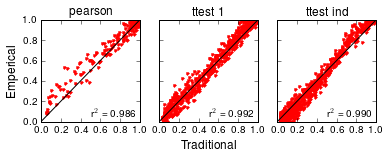

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'empr']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad']),
                                 np.hstack(dists.loc[name, 'empr']))
    ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Emperical', size=12)
axb.set_xlabel('Traditional', size=12)
fig = ax.figure
fig.savefig('/Users/jwdebelius/Desktop/model_check.pdf')

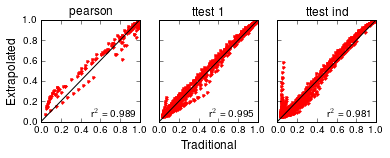

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'extr']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False],
                                 np.hstack(dists.loc[name, 'extr'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False])
    ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Extrapolated', size=12)
axb.set_xlabel('Traditional', size=12)

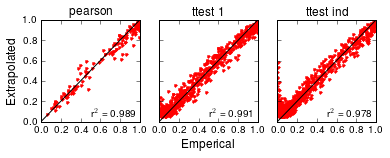

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'empr']),
            np.hstack(dists.loc[name, 'extr']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'empr'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False],
                                 np.hstack(dists.loc[name, 'extr'])[np.isnan(np.hstack(dists.loc[name, 'extr'])) == False])
    ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Extrapolated', size=12)
axb.set_xlabel('Emperical', size=12)

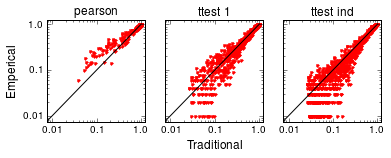

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'empr']),
            'r.')
    ax.plot(np.power(10., np.arange(-3, 1, 1)), np.power(10., np.arange(-3, 1, 1)), 'k-')
    ax.set_xlim(0.0075, 1.25)
    ax.set_ylim(0.0075, 1.25)
    ax.set_title(name.replace('_', ' '))
    ax.semilogx()
    ax.semilogy()
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad']),
                                 np.hstack(dists.loc[name, 'empr']))
#     ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Emperical', size=12)
axb.set_xlabel('Traditional', size=12)

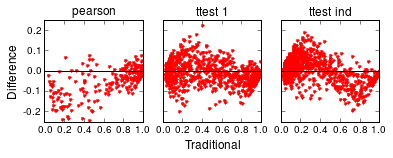

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            np.hstack(dists.loc[name, 'trad']) - np.hstack(dists.loc[name, 'empr']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), 0*np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.25, 0.25])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad']),
                                 np.hstack(dists.loc[name, 'empr']))
#     ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Difference', size=12)
axb.set_xlabel('Traditional', size=12)

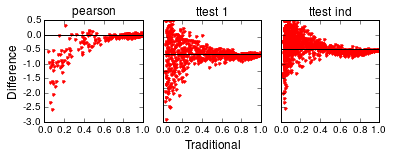

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
edge = []

fig = plt.figure()
for idx, name in enumerate(dists.index.values):
    ax = fig.add_subplot(2, 3, idx+1)
    ax.plot(np.hstack(dists.loc[name, 'trad']),
            (np.hstack(dists.loc[name, 'trad']) - np.hstack(dists.loc[name, 'empr']))/np.hstack(dists.loc[name, 'trad']),
            'r.')
    ax.plot(np.arange(0, 1.1, 0.1), 0*np.arange(0, 1.1, 0.1), 'k-')
    ax.set_xlim([0, 1])
#     ax.set_ylim([-0.25, 0.25])
    ax.set_title(name.replace('_', ' '))
    
    if idx not in {0, 3}:
        ax.set_yticklabels('')
    else:
        ax.set_yticklabels(ax.get_yticks())
    if idx not in {0, 1, 2}:
        ax.set_xticklabels('')
    else:
        ax.set_xticklabels(ax.get_xticks())
    r2, p = scipy.stats.pearsonr(np.hstack(dists.loc[name, 'trad']),
                                 np.hstack(dists.loc[name, 'empr']))
#     ax.text(0.95, 0.05, 'r$^2$ = %1.3f' % r2, ha='right')

ax0 = fig.axes[0]
axb = fig.axes[1]
ax0.set_ylabel('Difference', size=12)
axb.set_xlabel('Traditional', size=12)